Reading the data   

In [173]:
import pyarrow.parquet as pa
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
import numpy as np

driver_order = pa.read_table('data/masked_driver_order_mapping.parquet') 
driver_order = driver_order.to_pandas() 

order_articles = pa.read_table('data/masked_order_articles.parquet') 
order_articles = order_articles.to_pandas() 

orders = pa.read_table('data/masked_orders.parquet') 
orders = orders.to_pandas() 

service_time = pa.read_table('data/masked_service_times.parquet') 
service_time = service_time.to_pandas() 

# Taking tanspose so the printing dataset will easy. 
driver_order

,web_order_id,driver_id
0,51222,182
1,53503,182
2,166709,182
3,136190,182
4,176394,182
...,...,...
1534811,473982,9240
1534812,474113,9240
1534813,475628,9240
1534814,468676,9240


In [174]:
print(order_articles.describe())
order_articles


       warehouse_id        box_id    article_id  article_weight_in_g  \
count  1.558638e+07  8.091248e+06  1.558638e+07         1.558638e+07   
mean   2.237072e+01  2.451816e+07  1.024022e+04         7.909714e+03   
std    1.199967e+01  3.752282e+05  7.476332e+03         7.916583e+03   
min    1.000000e+00  0.000000e+00  6.000000e+00         6.000000e+00   
25%    1.200000e+01  2.419974e+07  3.541000e+03         3.660000e+02   
50%    2.300000e+01  2.451777e+07  8.484000e+03         1.353000e+03   
75%    3.200000e+01  2.484370e+07  1.769600e+04         1.695000e+04   
max    4.600000e+01  2.518101e+07  2.370500e+04         2.260000e+04   

       web_order_id  
count  1.558638e+07  
mean   7.653445e+05  
std    4.441621e+05  
min    1.000000e+00  
25%    3.822260e+05  
50%    7.570010e+05  
75%    1.155535e+06  
max    1.534834e+06  


,warehouse_id,box_id,article_id,article_weight_in_g,web_order_id
0,3,NaN,3657,17250,1250399
1,3,NaN,3657,17250,1250154
2,32,NaN,2576,17000,1296951
3,32,NaN,3975,15100,978668
4,25,NaN,3670,11000,104995
...,...,...,...,...,...
15586377,35,NaN,3953,17800,1533370
15586378,35,NaN,3953,17800,1533370
15586379,35,NaN,3953,17800,1533370
15586380,35,NaN,3953,17800,1533370


In [175]:
print(order_articles['box_id'].unique())

[      nan        0. 24510740. ... 24510737. 24510738. 24510739.]


In [176]:
orders


,warehouse_id,order_time,has_elevator,floor,is_pre_order,is_business,web_order_id,customer_id
0,18,2024-12-17 09:00:00+01:00,False,0.0,True,True,806432,166859
1,8,2024-12-10 09:45:00+01:00,False,0.0,True,True,678738,167463
2,8,2024-11-21 10:45:00+01:00,False,NaN,True,True,347665,49336
3,13,2024-11-08 10:00:00+01:00,False,0.0,True,True,110643,172552
4,13,2025-01-06 13:15:48.730000+01:00,False,NaN,False,True,1139043,136281
...,...,...,...,...,...,...,...,...
1534684,4,2024-11-27 15:45:00+01:00,False,0.0,True,True,460582,433427
1534685,6,2025-01-20 09:11:40.430000+01:00,False,0.0,False,True,1382719,404857
1534686,6,2024-11-26 08:45:00+01:00,False,0.0,True,True,419104,404857
1534687,6,2024-12-02 13:15:00+01:00,False,0.0,True,True,542528,393199


In [177]:
service_time

,service_time_start,service_time_end,service_time_in_minutes,order_datetime,web_order_id,driver_id,trip_id,customer_id
0,2024-11-11 21:48:59+01:00,2024-11-11 21:57:56+01:00,8.950000,2024-11-11 20:45:00+01:00,1,3621,29687,35422
1,2024-11-05 13:27:30+01:00,2024-11-05 13:45:05+01:00,17.583333,2024-11-05 13:15:00+01:00,2,6575,10097,159165
2,2024-11-05 21:52:03+01:00,2024-11-05 22:09:28+01:00,17.416666,2024-11-05 20:00:00+01:00,3,6811,12316,377355
3,2024-11-12 21:01:30.013000+01:00,2024-11-12 21:15:30.087000+01:00,14.000000,2024-11-12 19:00:00+01:00,4,5183,31795,146455
4,2024-11-01 15:28:07+01:00,2024-11-01 15:37:01+01:00,8.900000,2024-11-01 13:45:00+01:00,5,694,966,210296
...,...,...,...,...,...,...,...,...
1534829,2025-01-30 09:28:42+01:00,2025-01-30 09:33:43+01:00,5.016666,2025-01-30 08:10:51.200000+01:00,1534830,10536,250427,454002
1534830,2025-01-30 09:36:48+01:00,2025-01-30 09:45:29+01:00,8.683333,2025-01-30 08:13:38.747000+01:00,1534831,10755,250425,221139
1534831,2025-01-30 09:49:06+01:00,2025-01-30 09:58:29+01:00,9.383333,2025-01-30 08:15:32.833000+01:00,1534832,6570,250428,529887
1534832,2025-01-30 09:59:50+01:00,2025-01-30 10:07:27+01:00,7.616666,2025-01-30 08:47:31.837000+01:00,1534833,10925,250431,365722


joining the tables


In [178]:
# merged_data = pd.concat([orders, order_articles], axis=1, join="inner")
result1 = pd.merge(orders, order_articles, on=["web_order_id"])
result2 = pd.merge(result1, service_time, on=["web_order_id"])
result2

,warehouse_id_x,order_time,has_elevator,floor,is_pre_order,is_business,web_order_id,customer_id_x,warehouse_id_y,box_id,article_id,article_weight_in_g,service_time_start,service_time_end,service_time_in_minutes,order_datetime,driver_id,trip_id,customer_id_y
0,18,2024-12-17 09:00:00+01:00,False,0.0,True,True,806432,166859,18,NaN,2344,15050,2024-12-17 10:09:30.067000+01:00,2024-12-17 10:27:00.030000+01:00,17.500000,2024-12-17 09:00:00+01:00,9045,133625,166859
1,18,2024-12-17 09:00:00+01:00,False,0.0,True,True,806432,166859,18,NaN,2346,15050,2024-12-17 10:09:30.067000+01:00,2024-12-17 10:27:00.030000+01:00,17.500000,2024-12-17 09:00:00+01:00,9045,133625,166859
2,18,2024-12-17 09:00:00+01:00,False,0.0,True,True,806432,166859,18,NaN,1988,13900,2024-12-17 10:09:30.067000+01:00,2024-12-17 10:27:00.030000+01:00,17.500000,2024-12-17 09:00:00+01:00,9045,133625,166859
3,18,2024-12-17 09:00:00+01:00,False,0.0,True,True,806432,166859,18,NaN,2574,17250,2024-12-17 10:09:30.067000+01:00,2024-12-17 10:27:00.030000+01:00,17.500000,2024-12-17 09:00:00+01:00,9045,133625,166859
4,18,2024-12-17 09:00:00+01:00,False,0.0,True,True,806432,166859,18,NaN,2574,17250,2024-12-17 10:09:30.067000+01:00,2024-12-17 10:27:00.030000+01:00,17.500000,2024-12-17 09:00:00+01:00,9045,133625,166859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15585011,37,2024-12-06 11:15:00+01:00,False,0.0,True,False,608605,380052,37,NaN,1817,20600,2024-12-06 13:10:39+01:00,2024-12-06 13:23:55+01:00,13.266666,2024-12-06 11:15:00+01:00,9149,100124,380052
15585012,37,2024-12-06 11:15:00+01:00,False,0.0,True,False,608605,380052,37,24395771.0,3593,1350,2024-12-06 13:10:39+01:00,2024-12-06 13:23:55+01:00,13.266666,2024-12-06 11:15:00+01:00,9149,100124,380052
15585013,37,2024-12-06 11:15:00+01:00,False,0.0,True,False,608605,380052,37,24395771.0,3593,1350,2024-12-06 13:10:39+01:00,2024-12-06 13:23:55+01:00,13.266666,2024-12-06 11:15:00+01:00,9149,100124,380052
15585014,37,2024-12-06 11:15:00+01:00,False,0.0,True,False,608605,380052,37,24395771.0,3593,1350,2024-12-06 13:10:39+01:00,2024-12-06 13:23:55+01:00,13.266666,2024-12-06 11:15:00+01:00,9149,100124,380052


Dropping columns


In [179]:
result3 = result2.drop(['order_time', 'customer_id_x', 'warehouse_id_y', 'service_time_start', 'service_time_end', 'order_datetime', 'trip_id'], axis=1)
result3

,warehouse_id_x,has_elevator,floor,is_pre_order,is_business,web_order_id,box_id,article_id,article_weight_in_g,service_time_in_minutes,driver_id,customer_id_y
0,18,False,0.0,True,True,806432,NaN,2344,15050,17.500000,9045,166859
1,18,False,0.0,True,True,806432,NaN,2346,15050,17.500000,9045,166859
2,18,False,0.0,True,True,806432,NaN,1988,13900,17.500000,9045,166859
3,18,False,0.0,True,True,806432,NaN,2574,17250,17.500000,9045,166859
4,18,False,0.0,True,True,806432,NaN,2574,17250,17.500000,9045,166859
...,...,...,...,...,...,...,...,...,...,...,...,...
15585011,37,False,0.0,True,False,608605,NaN,1817,20600,13.266666,9149,380052
15585012,37,False,0.0,True,False,608605,24395771.0,3593,1350,13.266666,9149,380052
15585013,37,False,0.0,True,False,608605,24395771.0,3593,1350,13.266666,9149,380052
15585014,37,False,0.0,True,False,608605,24395771.0,3593,1350,13.266666,9149,380052


In [180]:
# Group by 'web_order_id' and count the number of 'box_id' 
# COUNT UNIQUE BOX IDS
num_boxes = result3.groupby('web_order_id')['box_id'].nunique().reset_index()

# Rename the column for clarity
num_boxes.rename(columns={'box_id': 'box_count'}, inplace=True)

print(num_boxes)

         web_order_id  box_count
0                   1          2
1                   2          0
2                   3          0
3                   4          4
4                   5          0
...               ...        ...
1534647       1534830          0
1534648       1534831          0
1534649       1534832          0
1534650       1534833          1
1534651       1534834          2

[1534652 rows x 2 columns]


In [181]:
result4 = pd.merge(result3, num_boxes, on=["web_order_id"])
result4

,warehouse_id_x,has_elevator,floor,is_pre_order,is_business,web_order_id,box_id,article_id,article_weight_in_g,service_time_in_minutes,driver_id,customer_id_y,box_count
0,18,False,0.0,True,True,806432,NaN,2344,15050,17.500000,9045,166859,0
1,18,False,0.0,True,True,806432,NaN,2346,15050,17.500000,9045,166859,0
2,18,False,0.0,True,True,806432,NaN,1988,13900,17.500000,9045,166859,0
3,18,False,0.0,True,True,806432,NaN,2574,17250,17.500000,9045,166859,0
4,18,False,0.0,True,True,806432,NaN,2574,17250,17.500000,9045,166859,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15585011,37,False,0.0,True,False,608605,NaN,1817,20600,13.266666,9149,380052,1
15585012,37,False,0.0,True,False,608605,24395771.0,3593,1350,13.266666,9149,380052,1
15585013,37,False,0.0,True,False,608605,24395771.0,3593,1350,13.266666,9149,380052,1
15585014,37,False,0.0,True,False,608605,24395771.0,3593,1350,13.266666,9149,380052,1


The problem I have is that in one order there are multiple articles. However, in total there are thousands of articles so I can't one-hot-encode. I dont want to have multiple rows that are the exact same but just differ in 2 columns, article_id and its weight.

## First approach will be to try and aggregrate the data. So number of articles and summing the weight. Second Approach is One-Hot-encoding whereby we will devide this into 2 subcategories. First, the value of the encoding will be 0 or 1 and second, the values will be 0 or the num of elements in the order.

# Important idea: We want to extract box_count, crate_count and the weights of the boxed (box_id_weight)


In [182]:
# Aggregate articles as lists, sum weights, and count total articles
result5 = result4.groupby('web_order_id').agg({
    'article_id': [list, 'count'],  # Store articles in a list and count total
    'article_weight_in_g': 'sum'  # Sum of article weights
}).reset_index()

# Rename columns for clarity
result5.columns = ['web_order_id', 'articles', 'total_articles', 'total_weight']



In [183]:
result5 = result5[['web_order_id','total_articles', 'total_weight']]
result5


,web_order_id,total_articles,total_weight
0,1,17,20443
1,2,4,56400
2,3,11,189750
3,4,24,54191
4,5,7,79590
...,...,...,...
1534647,1534830,6,88800
1534648,1534831,4,71200
1534649,1534832,10,153502
1534650,1534833,3,33738


In [187]:
result6 = pd.merge(result5, result4 , on=["web_order_id"])
result6 = result6.drop(['article_weight_in_g'], axis=1)

# Count NaNs in 'box id' per 'order id' and store in 'crate count'
result6['crate_count'] = result6.groupby('web_order_id')['box_id'].transform(lambda x: x.isna().sum())

result6

,web_order_id,total_articles,total_weight,warehouse_id_x,has_elevator,floor,is_pre_order,is_business,box_id,article_id,service_time_in_minutes,driver_id,customer_id_y,box_count,crate_count
0,1,17,20443,27,True,7.0,True,False,NaN,1302,8.950000,3621,35422,2,1
1,1,17,20443,27,True,7.0,True,False,24020218.0,9922,8.950000,3621,35422,2,1
2,1,17,20443,27,True,7.0,True,False,24020219.0,19488,8.950000,3621,35422,2,1
3,1,17,20443,27,True,7.0,True,False,24020219.0,22954,8.950000,3621,35422,2,1
4,1,17,20443,27,True,7.0,True,False,24020219.0,22312,8.950000,3621,35422,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15585011,1534834,16,34769,17,True,5.0,False,False,25181008.0,21371,10.866666,10925,423647,2,2
15585012,1534834,16,34769,17,True,5.0,False,False,25181008.0,21374,10.866666,10925,423647,2,2
15585013,1534834,16,34769,17,True,5.0,False,False,25181008.0,21372,10.866666,10925,423647,2,2
15585014,1534834,16,34769,17,True,5.0,False,False,25181008.0,18046,10.866666,10925,423647,2,2


In [190]:
# Assuming 'result6' is your DataFrame
filtered_df = result6[result6['crate_count'] == 3]

print(filtered_df)


          web_order_id  total_articles  total_weight  warehouse_id_x  \
63                   6               8         45982              15   
64                   6               8         45982              15   
65                   6               8         45982              15   
66                   6               8         45982              15   
67                   6               8         45982              15   
...                ...             ...           ...             ...   
15584945       1534826               6         92301              17   
15584946       1534826               6         92301              17   
15584947       1534826               6         92301              17   
15584948       1534826               6         92301              17   
15584949       1534826               6         92301              17   

          has_elevator  floor  is_pre_order  is_business      box_id  \
63                True    6.0          True        False       

# Training and test split

In [196]:
result7 = result6.drop(['article_id', 'warehouse_id_x', 'box_id', 'total_weight'], axis=1)
result7 = result7.drop_duplicates(subset=['web_order_id'])
result7['floor'] = result7['floor'].fillna(0)
# result7['driver_id'] = result7['driver_id'].astype(str)



X = result7.drop(['service_time_in_minutes'], axis=1)
y = result7[['service_time_in_minutes']]
result7['customer_id'] = result7['customer_id_y'].astype(str)
result7['driver_id'] = result7['driver_id'].astype(str)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)


result7


,web_order_id,total_articles,has_elevator,floor,is_pre_order,is_business,service_time_in_minutes,driver_id,customer_id_y,box_count,crate_count,customer_id
0,1,17,True,7.0,True,False,8.950000,3621,35422,2,1,35422
17,2,4,False,2.0,True,False,17.583333,6575,159165,0,4,159165
21,3,11,False,1.0,True,False,17.416666,6811,377355,0,11,377355
32,4,24,False,2.0,True,False,14.000000,5183,146455,4,4,146455
56,5,7,True,0.0,True,False,8.900000,694,210296,0,7,210296
...,...,...,...,...,...,...,...,...,...,...,...,...
15584977,1534830,6,False,0.0,False,False,5.016666,10536,454002,0,6,454002
15584983,1534831,4,False,3.0,False,False,8.683333,10755,221139,0,4,221139
15584987,1534832,10,True,-1.0,False,True,9.383333,6570,529887,0,10,529887
15584997,1534833,3,True,1.0,False,False,7.616666,10925,365722,1,2,365722


In [197]:
print(result7.isna().sum())
print(result7.dtypes)



web_order_id               0
total_articles             0
has_elevator               0
floor                      0
is_pre_order               0
is_business                0
service_time_in_minutes    0
driver_id                  0
customer_id_y              0
box_count                  0
crate_count                0
customer_id                0
dtype: int64
web_order_id                 int64
total_articles               int64
has_elevator                  bool
floor                      float64
is_pre_order                  bool
is_business                   bool
service_time_in_minutes    float64
driver_id                   object
customer_id_y                int64
box_count                    int64
crate_count                  int64
customer_id                 object
dtype: object


# Training the Random Forest

In [198]:
regressor = RandomForestRegressor(n_estimators=20, random_state=0,max_depth=10,min_samples_leaf=5,min_samples_split=10, oob_score=True)

regressor.fit(X_train, y_train)

/opt/anaconda3/envs/web_mining/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/web_mining/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomForestRegressor(max_depth=10, min_samples_leaf=5, min_samples_split=10,
                      n_estimators=20, oob_score=True, random_state=0)

In [199]:
oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

predictions = regressor.predict(X_train)

mse = mean_squared_error(y_train, predictions)
print(f'Mean Squared Error: {mse}')

mae = mean_absolute_error(y_train, predictions)
print(f'Mean Absolute Error: {mae}')

r2 = r2_score(y_train, predictions)
print(f'R-squared: {r2}')

# Old array fit
# Out-of-Bag Score: 0.6799009762762025
# Mean Squared Error: 1.249703034044174
# R-squared: 0.9782934136908276

Out-of-Bag Score: 0.37368099953286127
Mean Squared Error: 23.473723907819696
Mean Absolute Error: 3.2186630668401905
R-squared: 0.39261972392850475


In [200]:
oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

predictions = regressor.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error: {mae}')

r2 = r2_score(y_test, predictions)
print(f'R-squared: {r2}')

# Old array fit
# Out-of-Bag Score: 0.27332230416311387
# Mean Squared Error: 25.912095943177313
# Mean Absolute Error: 3.379660892889273
# R-squared: 0.3375366959313808

Out-of-Bag Score: 0.37368099953286127
Mean Squared Error: 24.59161059198917
Mean Absolute Error: 3.249629223085388
R-squared: 0.3712959522509236


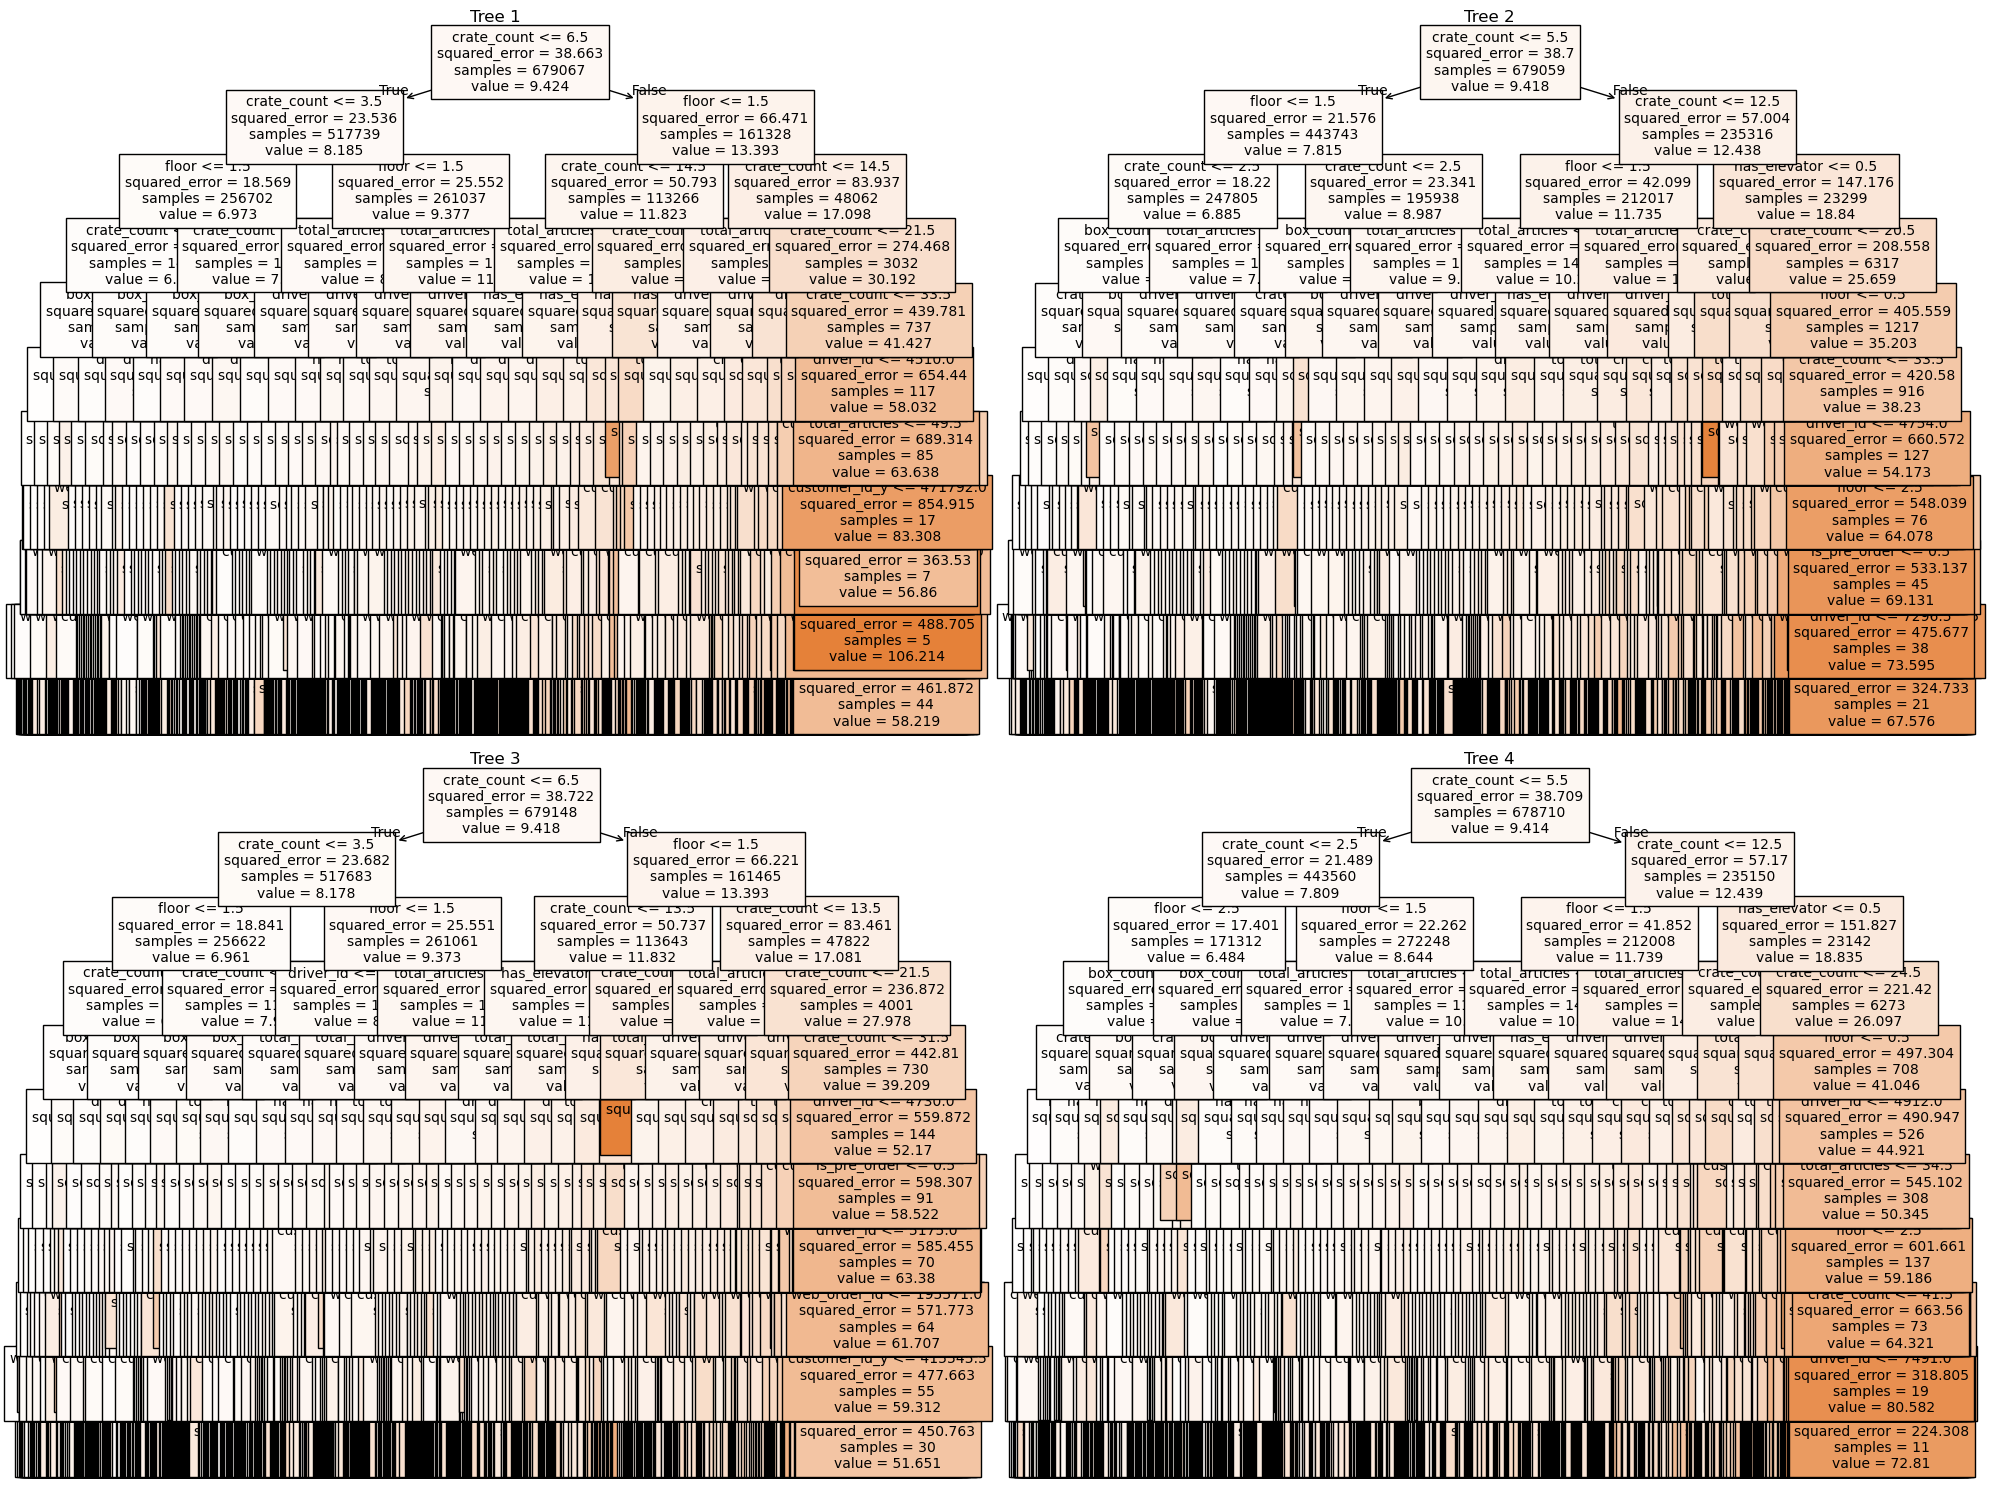

In [201]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Set up the figure size
plt.figure(figsize=(20, 15))

# Loop through the first 4 trees and plot them
for i in range(4):
    plt.subplot(2, 2, i+1)  # Create a subplot (2x2 grid)
    plot_tree(regressor.estimators_[i], filled=True, feature_names=X_train.columns, fontsize=10)
    plt.title(f"Tree {i+1}")

# Display the plot
plt.tight_layout()
plt.show()


# XGBoost


MSE of the base model: 24.140 and gamme: 0.0
MSE of the base model: 24.140 and gamme: 0.1
MSE of the base model: 24.140 and gamme: 0.2
MSE of the base model: 24.140 and gamme: 0.30000000000000004
MSE of the base model: 24.140 and gamme: 0.4
MSE of the base model: 24.140 and gamme: 0.5
MSE of the base model: 24.140 and gamme: 0.6000000000000001
MSE of the base model: 24.140 and gamme: 0.7000000000000001
MSE of the base model: 24.140 and gamme: 0.8
MSE of the base model: 24.140 and gamme: 0.9
MSE of the base model: 24.140 and gamme: 1.0
MSE of the base model: 24.140 and gamme: 1.1
MSE of the base model: 24.129 and gamme: 1.2000000000000002
MSE of the base model: 24.129 and gamme: 1.3000000000000003
MSE of the base model: 24.129 and gamme: 1.4000000000000004
MSE of the base model: 24.129 and gamme: 1.5000000000000004
MSE of the base model: 24.133 and gamme: 1.6000000000000005
MSE of the base model: 24.133 and gamme: 1.7000000000000006
MSE of the base model: 24.133 and gamme: 1.8000000000000007
MSE of the base model: 24.133 and gamme: 1.9000000000000008
MSE of the base model: 24.133 and gamme: 2.000000000000001
MSE of the base model: 24.133 and gamme: 2.100000000000001
MSE of the base model: 24.133 and gamme: 2.200000000000001
MSE of the base model: 24.133 and gamme: 2.300000000000001
MSE of the base model: 24.133 and gamme: 2.4000000000000012
MSE of the base model: 24.133 and gamme: 2.5000000000000013
MSE of the base model: 24.133 and gamme: 2.6000000000000014
MSE of the base model: 24.133 and gamme: 2.7000000000000015
MSE of the base model: 24.133 and gamme: 2.8000000000000016
MSE of the base model: 24.133 and gamme: 2.9000000000000017

In [202]:
# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)



# # Define hyperparameters

# for i in np.arange(1, 10):
#    for j in np.arange(0,3,0.1):

#       params = {"objective": "reg:squarederror", "max_depth": i,"gamma": j}

#       n = 1000
#       model = xgb.train(
#          params=params,
#          dtrain=dtrain_reg,
#          num_boost_round=n,
#       )

#       preds = model.predict(dtest_reg)

#       mse = mean_squared_error(y_test, preds)

#       # import numpy as np

#       # mse = np.mean((actual - predicted) ** 2)
#       # rmse = np.sqrt(mse)

#       print(f"MSE of the base model: {mse:.3f} and depth: {i} and gamma: {j}")
#       ar_mse = []
      




In [203]:
# Due to previous Hyperparameter optimization we will use i = 1.4 and depth=1.9

params = {"objective": "reg:squarederror", "max_depth": 6,"gamma": 1.8}

n = 1000
model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
)

preds = model.predict(dtest_reg)

mse = mean_squared_error(y_test, preds)

# import numpy as np

# mse = np.mean((actual - predicted) ** 2)
# rmse = np.sqrt(mse)

print(f"MSE of the base model: {mse:.3f}")

MSE of the base model: 24.386


## 10-fold-cross-Validation

In [204]:
# dtrain_reg_one = xgb.DMatrix(X_train.iloc[:int(0.7 * len(X_train))], y_train.iloc[:int(0.7 * len(y_train))], enable_categorical=True)
# dtrain_reg_validation = xgb.DMatrix(X_train.iloc[int(0.7 * len(X_train)):], y_train.iloc[int(0.7 * len(y_train)):], enable_categorical=True)

# evals = [(dtrain_reg, "train"), (dtrain_reg_validation, "validation")]
# n = 50
# model = xgb.train(
#    params=params,
#    dtrain=dtrain_reg,
#    num_boost_round=n,
#    evals=evals,
#    verbose_eval=50,
#    # Activate early stopping
#    early_stopping_rounds=50
# )

# Perform 10-fold Cross-Validation
cv_results = xgb.cv(
    params=params, 
    dtrain=dtrain_reg,
    num_boost_round=1000,  # Number of boosting rounds
    nfold=10,  # 10-Fold Cross Validation
    metrics=["rmse"],  # Evaluation metric
    early_stopping_rounds=10,  # Stop if no improvement for 10 rounds
    as_pandas=True,  # Return result as Pandas DataFrame
    seed=42
)

# Print final RMSE score
print(cv_results)
print(f"Best iteration: {cv_results.shape[0]}")
print(f"Final RMSE: {cv_results['test-rmse-mean'].min():.4f}")

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0          5.657545        0.004140        5.660259       0.040978
1          5.336179        0.004576        5.342213       0.037422
2          5.155924        0.004293        5.162733       0.035054
3          5.051415        0.003507        5.059946       0.034335
4          4.988639        0.003670        4.999743       0.032690
..              ...             ...             ...            ...
58         4.788669        0.002659        4.871060       0.026425
59         4.787619        0.002568        4.870930       0.026308
60         4.786849        0.002531        4.870875       0.026284
61         4.786063        0.002722        4.870878       0.026358
62         4.785121        0.002858        4.870864       0.026333

[63 rows x 4 columns]
Best iteration: 63
Final RMSE: 4.8709


In [205]:
best_rounds = cv_results.shape[0]  # Get the best iteration number
print(f"Best number of boosting rounds: {best_rounds}")

model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=best_rounds  # Use the best iteration from CV
)

Best number of boosting rounds: 63


In [206]:
preds = model.predict(dtest_reg)

rmse = root_mean_squared_error(y_test, preds)

# import numpy as np
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, preds)
# mse = np.mean((actual - predicted) ** 2)
# rmse = np.sqrt(mse)

print(f"MSE of the base model: {rmse:.3f}")
print(f"MAE of the base model: {mae:.3f}")

MSE of the base model: 4.919
MAE of the base model: 3.211


In [207]:
model_params = model.save_config()  # Gets all parameters
print(model_params)

{"learner":{"generic_param":{"device":"cpu","fail_on_invalid_gpu_id":"0","n_jobs":"0","nthread":"0","random_state":"0","seed":"0","seed_per_iteration":"0","validate_parameters":"1"},"gradient_booster":{"gbtree_model_param":{"num_parallel_tree":"1","num_trees":"63"},"gbtree_train_param":{"process_type":"default","tree_method":"auto","updater":"grow_quantile_histmaker","updater_seq":"grow_quantile_histmaker"},"name":"gbtree","specified_updater":false,"tree_train_param":{"alpha":"0","cache_opt":"1","colsample_bylevel":"1","colsample_bynode":"1","colsample_bytree":"1","eta":"0.300000012","gamma":"1.79999995","grow_policy":"depthwise","interaction_constraints":"","lambda":"1","learning_rate":"0.300000012","max_bin":"256","max_cat_threshold":"64","max_cat_to_onehot":"4","max_delta_step":"0","max_depth":"6","max_leaves":"0","min_child_weight":"1","min_split_loss":"1.79999995","monotone_constraints":"()","refresh_leaf":"1","reg_alpha":"0","reg_lambda":"1","sampling_method":"uniform","sketch_ra